### Nixtla Machine learning forecast

mlforecast is a framework to perform time series forecasting using machine learning models, with the option to scale to massive amounts of data using remote clusters.

source: https://nixtlaverse.nixtla.io/mlforecast/index.html

## how to use

In [1]:
# ! pip install mlforecast

In [2]:
import pandas as pd

### 1. generate data

In [3]:
from mlforecast.utils import generate_daily_series

In [4]:
series = generate_daily_series(
    n_series=20,
    max_length=100, # es el largo máximo pero pueden series de largo menor
    n_static_features=1,
    static_as_categorical=False, # cada serie tiene su única valor static
    with_trend=True
)

In [5]:
series.head()

,unique_id,ds,y,static_0
0,id_00,2000-01-01,17.519167,72
1,id_00,2000-01-02,87.799695,72
2,id_00,2000-01-03,177.442975,72
3,id_00,2000-01-04,232.704110,72
4,id_00,2000-01-05,317.510474,72


In [6]:
series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  1461 non-null   category      
 1   ds         1461 non-null   datetime64[ns]
 2   y          1461 non-null   float64       
 3   static_0   1461 non-null   int64         
dtypes: category(1), datetime64[ns](1), float64(1), int64(1)
memory usage: 36.5 KB


In [7]:
# 20 series
series['unique_id'].unique()

['id_00', 'id_01', 'id_02', 'id_03', 'id_04', ..., 'id_15', 'id_16', 'id_17', 'id_18', 'id_19']
Length: 20
Categories (20, object): ['id_00', 'id_01', 'id_02', 'id_03', ..., 'id_16', 'id_17', 'id_18', 'id_19']

In [8]:
series['ds'].min()

Timestamp('2000-01-01 00:00:00')

In [9]:
series['ds'].max() # 100 días de datos de cada serie

Timestamp('2000-04-09 00:00:00')

In [10]:
# Note: The unique_id serves as an identifier for each distinct time series in your dataset. 
# If you are using only single time series from your dataset, set this column to a constant value.

In [11]:
# revisar columna static
series['static_0'].unique()

array([72, 75, 97, 78, 38, 11, 74, 89, 32, 50, 40, 70, 30, 22, 35, 84, 68,
       63,  4])

### 2. Fast EDA
Realizar un EDA rápido del dataset

In [12]:
# revisar el largo de cada conjunto de datos
for id in series['unique_id'].unique().tolist():
    len_serie = series[series['unique_id'] == id].shape[0]
    print(f'{id}: {len_serie}')

id_00: 94
id_01: 97
id_02: 50
id_03: 53
id_04: 53
id_05: 89
id_06: 59
id_07: 69
id_08: 71
id_09: 100
id_10: 86
id_11: 73
id_12: 56
id_13: 74
id_14: 74
id_15: 62
id_16: 51
id_17: 88
id_18: 89
id_19: 73


In [13]:
# revisar serie que son más cortas
series[series['unique_id'] == 'id_18']

,unique_id,ds,y,static_0
1299,id_18,2000-01-01,273.575592,63
1300,id_18,2000-01-02,340.769298,63
1301,id_18,2000-01-03,402.627424,63
1302,id_18,2000-01-04,9.318493,63
1303,id_18,2000-01-05,71.814126,63
...,...,...,...,...
1383,id_18,2000-03-25,292.254203,63
1384,id_18,2000-03-26,360.333461,63
1385,id_18,2000-03-27,410.076951,63
1386,id_18,2000-03-28,21.258681,63


In [14]:
series['unique_id'].unique().tolist()

['id_00',
 'id_01',
 'id_02',
 'id_03',
 'id_04',
 'id_05',
 'id_06',
 'id_07',
 'id_08',
 'id_09',
 'id_10',
 'id_11',
 'id_12',
 'id_13',
 'id_14',
 'id_15',
 'id_16',
 'id_17',
 'id_18',
 'id_19']

In [15]:
# pivotear. Una serie por columna
df_to_eda = series.pivot(index='ds', columns='unique_id', values=['y', 'static_0'])
df_to_eda = df_to_eda.reset_index().set_index('ds') # fijar indice
df_to_eda.columns = df_to_eda.columns.map('|'.join).str.strip('|') # nombre de las columnas
df_to_eda.head(2)

,y|id_00,y|id_01,y|id_02,y|id_03,y|id_04,y|id_05,y|id_06,y|id_07,y|id_08,y|id_09,...,static_0|id_10,static_0|id_11,static_0|id_12,static_0|id_13,static_0|id_14,static_0|id_15,static_0|id_16,static_0|id_17,static_0|id_18,static_0|id_19
ds,,,,,,,,,,,,,,,,,,,,,
2000-01-01,17.519167,243.051734,226.265238,266.506272,18.061152,48.882083,164.315993,457.585938,146.954845,259.821098,...,40.0,70.0,30.0,22.0,75.0,35.0,84.0,68.0,63.0,4.0
2000-01-02,87.799695,338.356765,321.218308,320.140176,46.321134,61.206988,251.817868,581.554105,175.497757,329.170937,...,40.0,70.0,30.0,22.0,75.0,35.0,84.0,68.0,63.0,4.0


In [16]:
# dropna
df_to_eda.shape

(100, 40)

In [17]:
df_to_eda.dropna(inplace = True)

In [18]:
df_to_eda.shape

(50, 40)

In [19]:
df_to_eda[['y|id_00', 'static_0|id_00']].head(3)

,y|id_00,static_0|id_00
ds,,
2000-01-01,17.519167,72.0
2000-01-02,87.799695,72.0
2000-01-03,177.442975,72.0


<Axes: xlabel='ds'>

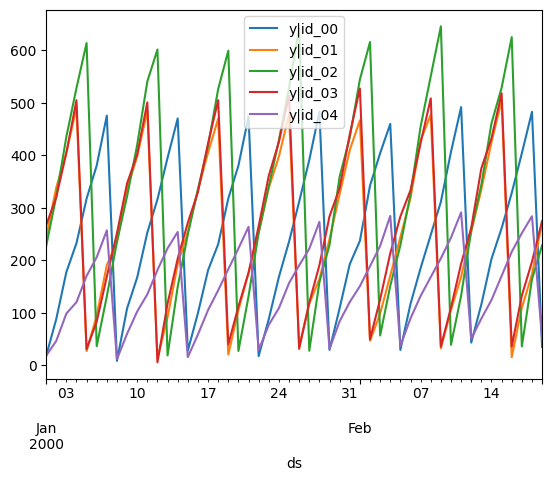

In [20]:
# plot trend. first 5
fist_5_columns = df_to_eda.columns[0:5]
df_to_eda[fist_5_columns].plot()

In [21]:
# statistics
df_to_eda.describe(percentiles = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])

,y|id_00,y|id_01,y|id_02,y|id_03,y|id_04,y|id_05,y|id_06,y|id_07,y|id_08,y|id_09,...,static_0|id_10,static_0|id_11,static_0|id_12,static_0|id_13,static_0|id_14,static_0|id_15,static_0|id_16,static_0|id_17,static_0|id_18,static_0|id_19
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0
mean,245.083398,254.291546,333.269239,269.353463,148.458620,45.015509,257.807276,322.290438,131.017179,173.946393,...,40.0,70.0,30.0,22.0,75.0,35.0,84.0,68.0,63.0,4.0
std,151.870307,152.712910,196.400302,157.864757,82.765580,24.132921,150.890997,181.529037,66.383291,106.025335,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,8.364154,12.872631,18.862160,5.673888,11.730224,4.216836,11.935175,16.821845,6.705698,0.732881,...,40.0,70.0,30.0,22.0,75.0,35.0,84.0,68.0,63.0,4.0
5%,22.172367,23.477205,31.477539,33.279745,23.050478,7.123949,30.640790,43.432533,32.353174,15.672572,...,40.0,70.0,30.0,22.0,75.0,35.0,84.0,68.0,63.0,4.0
10%,29.377649,35.775187,38.737888,39.393023,36.276271,12.044627,44.399539,71.555588,40.848520,19.220239,...,40.0,70.0,30.0,22.0,75.0,35.0,84.0,68.0,63.0,4.0
25%,110.626651,111.662335,159.703161,127.526172,85.183866,24.397437,122.080677,161.303091,77.984311,68.768054,...,40.0,70.0,30.0,22.0,75.0,35.0,84.0,68.0,63.0,4.0
50%,236.277309,248.221110,330.604578,269.025553,146.846727,48.528161,250.987823,313.303482,136.553608,178.257597,...,40.0,70.0,30.0,22.0,75.0,35.0,84.0,68.0,63.0,4.0
75%,380.716820,398.314121,527.835522,403.874328,220.638621,65.839662,394.459957,478.198015,184.139961,276.684047,...,40.0,70.0,30.0,22.0,75.0,35.0,84.0,68.0,63.0,4.0
90%,470.706320,470.743080,602.945981,505.052323,257.751263,75.139943,463.687230,581.775337,216.257798,322.490287,...,40.0,70.0,30.0,22.0,75.0,35.0,84.0,68.0,63.0,4.0


### 3. Models
Next define your models, each one will be trained on all series. These can be any regressor that follows the scikit-learn API.

In [22]:
import lightgbm as lgb
from sklearn.linear_model import LinearRegression

In [23]:
models = [
    lgb.LGBMRegressor(random_state=0, verbosity=-1),
    LinearRegression(),
]

#### Forecast object
Now instantiate an MLForecast object with the models and the features that you want to use. The features can be lags, transformations on the lags and date features. You can also define transformations to apply to the target before fitting, which will be restored when predicting.

In [24]:
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences

In [25]:
fcst = MLForecast(
    models=models,
    freq='D',
    lags=[7, 14],
    lag_transforms={
        1: [ExpandingMean()],
        7: [RollingMean(window_size=28)]
    },
    date_features=['dayofweek'],
    target_transforms=[Differences([1])],
)

#### Training

In [26]:
# probar cambiar el nombre de las columnas
list_columns = series.columns.tolist()
list_columns[-1]  = 'columna_prueba'
series.columns = list_columns
series.head(2)

,unique_id,ds,y,columna_prueba
0,id_00,2000-01-01,17.519167,72
1,id_00,2000-01-02,87.799695,72


In [27]:
fcst.fit(series)

MLForecast(models=[LGBMRegressor, LinearRegression], freq=D, lag_features=['lag7', 'lag14', 'expanding_mean_lag1', 'rolling_mean_lag7_window_size28'], date_features=['dayofweek'], num_threads=1)

#### Predicting

In [28]:
predictions = fcst.predict(5)
predictions

,unique_id,ds,LGBMRegressor,LinearRegression
0,id_00,2000-04-04,299.923771,311.432371
1,id_00,2000-04-05,365.424147,379.466214
2,id_00,2000-04-06,432.562441,460.234028
3,id_00,2000-04-07,495.628000,524.278924
4,id_00,2000-04-08,60.786223,79.828767
...,...,...,...,...
95,id_19,2000-03-14,56.046021,54.496159
96,id_19,2000-03-15,60.613630,59.624819
97,id_19,2000-03-16,25.310980,29.327854
98,id_19,2000-03-17,30.383420,33.876237


In [29]:
#predictions.pivot(index='ds', columns='unique_id', values=['y', 'static_0'])

### 5. Visualize results

In [30]:
from utilsforecast.plotting import plot_series

In [31]:
fig = plot_series(series, predictions, max_ids=4, plot_random=False)

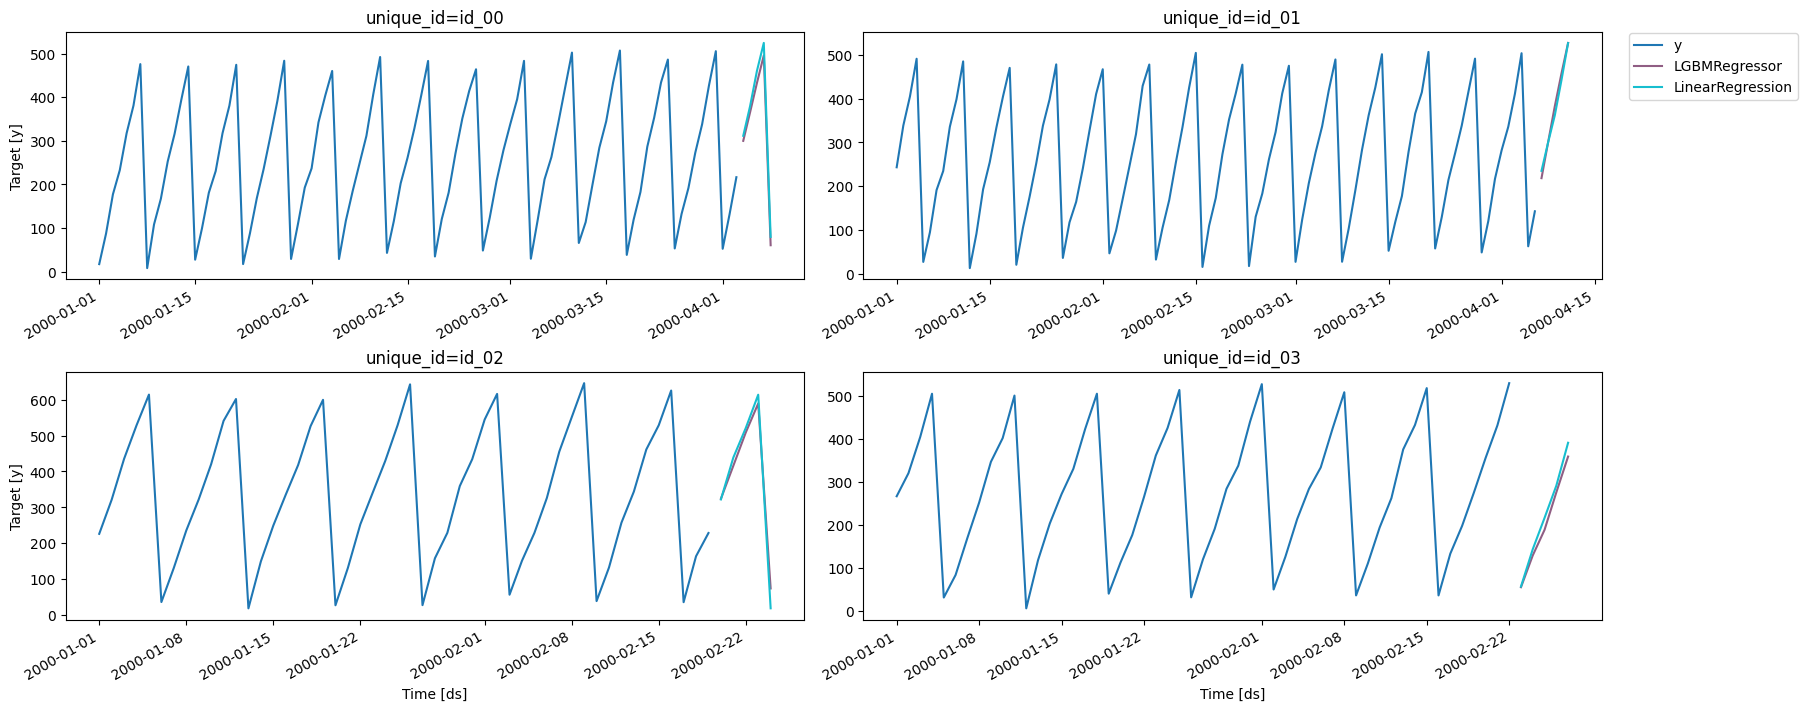

In [32]:
fig

In [33]:
### ver los datos con las trasformaciones

In [34]:
fcst.preprocess(series)

,unique_id,ds,y,columna_prueba,lag7,lag14,expanding_mean_lag1,rolling_mean_lag7_window_size28,dayofweek
35,id_00,2000-02-05,-430.702596,72,-454.058620,-456.530375,13.013610,0.423907,5
36,id_00,2000-02-06,87.790540,72,79.416692,70.494425,0.336004,0.750199,6
37,id_00,2000-02-07,68.248825,72,84.021957,80.358734,2.765297,0.549437,0
38,id_00,2000-02-08,63.141455,72,44.151060,67.095036,4.535122,0.152649,1
39,id_00,2000-02-09,63.001354,72,105.237348,76.114648,6.077394,0.882327,2
...,...,...,...,...,...,...,...,...,...
1456,id_19,2000-03-09,-30.071284,4,-29.834345,-28.439540,0.712994,0.349724,3
1457,id_19,2000-03-10,5.299399,4,4.921499,4.269643,0.260284,0.307237,4
1458,id_19,2000-03-11,5.037482,4,7.596848,7.351448,0.333314,0.429557,5
1459,id_19,2000-03-12,4.796646,4,5.135139,5.644122,0.400517,0.415544,6


### 6. MIS DUDAS
- Para hacer el forecast de las series, se consideran solo componentes autoregresivos de dichas series o se consideran las otras series? Se relacionan las series entre si?
- La variable exógena se utiliza?
- Cómo se puede hacer forecast con N horizonte a futuro
- Acá se entrena un modelo distinto para cada serie. O es un único modelo donde al pasar el índice como feature, el modelo lo reconoce y entrena con este?